In [2]:
%matplotlib inline
import os
import json
import random
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import gtfs_kit as gk
import numpy as np
import osmnx as ox
import networkx as nx
from tqdm import tqdm
from shapely.geometry import Polygon, LineString, Point
import warnings
warnings.filterwarnings('ignore')
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark import SparkConf
import pandas as pd
import pickle
from tqdm import tqdm
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/01/23 16:16:08 WARN Utils: Your hostname, Slade-173477 resolves to a loopback address: 127.0.1.1; using 10.2.219.10 instead (on interface eno1)
23/01/23 16:16:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/23 16:16:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Calculate with MTA disruptions dataset

In [3]:
# Get service disruption dataset
fp = os.path.join('data/Service Disruptions_07_2019_08_2022.csv')
disruptions_df = pd.read_csv(fp)
disruptions_df.head()
disruptions_df['DATETIME'] = disruptions_df['DATE'] + ' ' + disruptions_df['TIME']
disruptions_df['DATE'] = pd.to_datetime(disruptions_df['DATE'], format='%m/%d/%y', errors='coerce')
disruptions_df['TIME'] = pd.to_datetime(disruptions_df['TIME'], format='%H:%M:%S', errors='coerce')
disruptions_df['DATETIME'] = pd.to_datetime(disruptions_df['DATETIME'], format='%m/%d/%y %H:%M:%S', errors='coerce')

# Remove mechanical and weather disruptions
disruptions_df = disruptions_df.query("REASON != 'Mechanical' and REASON != 'Weather'")

disruptions_df['BLOCK'] = disruptions_df['BLOCK'].astype('int32')# disruptions_sp = disruptions_sp.withColumn("BLOCK", F.col("BLOCK").cast(IntegerType()))
disruptions_counts_df = disruptions_df.groupby('START_STOP_ABBR').agg('count')[['REASON']].reset_index().sort_values('REASON')

# Count the number of trips throughout this time
start_date = disruptions_df.sort_values(by=['DATETIME']).iloc[0]['DATETIME']
end_date   = disruptions_df.sort_values(by=['DATETIME']).iloc[-1]['DATETIME']

print(start_date, end_date)

# Filter APC data on these dates
# # filter subset
get_columns = ['transit_date', 'trip_id', 'departure_time', 'stop_id_original']
get_str = ", ".join([c for c in get_columns])

f = os.path.join('data/apc_weather_gtfs_20221216.parquet')
apcdata = spark.read.load(f)
apcdata.createOrReplaceTempView("apc")
query = f"""
SELECT {get_str}
FROM apc
WHERE (transit_date >= '{start_date.date()}') AND (transit_date <= '{end_date.date()}')
"""
apcdataafternegdelete = spark.sql(query)
apcdataafternegdelete = apcdataafternegdelete.dropna()
trips_df = apcdataafternegdelete.toPandas()
trips_df = trips_df.groupby('stop_id_original').agg('count').sort_values('trip_id').reset_index()

# Merging them toegether
merged_df = pd.merge(trips_df, disruptions_counts_df[['START_STOP_ABBR', 'REASON']], left_on='stop_id_original', right_on='START_STOP_ABBR')
merged_df['probability'] = merged_df['REASON'] / merged_df['transit_date']
merged_df['probability'] = merged_df['probability']/merged_df['probability'].max()
merged_df.sort_values('probability').tail(10)

all_stop_probabilities = trips_df[['stop_id_original']]
all_stop_probabilities = pd.merge(all_stop_probabilities, merged_df[['stop_id_original', 'probability']], on='stop_id_original', how='outer').fillna(0)
all_stop_probabilities.sort_values('probability')

fp = os.path.join('data/disruption_probabilities.pkl')
all_stop_probabilities.to_pickle(fp)
all_stop_probabilities

2020-03-21 06:28:00 2022-08-12 06:38:00


,stop_id_original,probability
0,DKWM,0.000000
1,ETHGLESF,0.000000
2,RHAB,0.000000
3,THOLANWF,0.000000
4,THOGRAWN,0.000000
...,...,...
2068,JAM5AEN,0.000000
2069,DWMRT,0.001027
2070,4AVCHUSN,0.000000
2071,CHA7AEN,0.000000


In [11]:
a = all_stop_probabilities.query("probability > 0.0 and probability <= 0.1").sort_values('probability')
np.random.choice(a.stop_id_original, 31)

array(['CXI53AVE', 'MCC5_6', 'NOLWELSF', 'NXOFRGND', 'MXITHOMP',
       'WHIMOONN', 'GXIRIVEF', 'WES31AEM', 'MCSHERM', 'ELIHYDNF',
       'WHGRENN', 'CXORICHL', 'CXOWTBRG', 'OLDFORT', 'WHIMOONN', 'WALTPR',
       'BOYBUENN', 'MUSICVAL', 'GWYEWISM', 'PONATHE2', 'DOLL', '19SSHESN',
       'LEBOLDNN', 'TEN50AWN', 'LEBOLDNN', 'MCC5_5', 'MXIWHARF',
       'GXORIVEN', 'DOVDICWF', 'NXITHMPN', 'GXOFIVEF'], dtype=object)

# Calculate first with the waze incidents

32
32


600it [00:02, 211.87it/s]


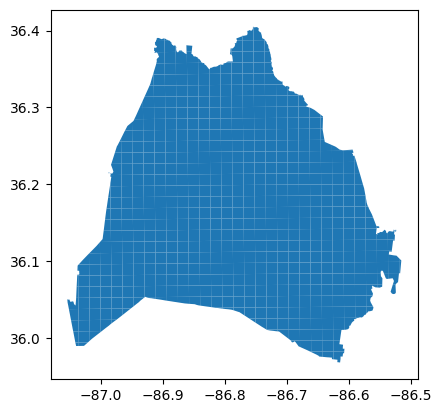

In [3]:
from shapely import wkt
import glob

waze_df = pd.read_csv('data/nashville_2020_2022.csv')
waze_df['geometry'] = waze_df['geo'].apply(wkt.loads)
waze_df = gpd.GeoDataFrame(waze_df, crs='epsg:4326')
# waze_df['datetime'] = pd.to_datetime()
cols = ['date', 'hour', 'minute', 'second']
waze_df['datetime'] = waze_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
waze_df['datetime'] = pd.to_datetime(waze_df['datetime'], format="%Y-%m-%d %H %M %S")
waze_df = waze_df.query("type == 'ACCIDENT'")
waze_df.head(1)
listfiles = glob.glob('data/raw_gtfs/*.zip')
routes_arr = []
stops_arr = []
for lf in listfiles:
    feed = gk.read_feed(lf, dist_units='mi')
    routes = feed.geometrize_routes()
    stops = feed.geometrize_stops()
    routes_arr.append(routes)
    stops_arr.append(stops)
    
routes = pd.concat(routes_arr)
routes = routes.drop_duplicates()

stops = pd.concat(stops_arr)
stops = stops.drop_duplicates(subset='stop_id')
stops = stops.reset_index(drop=True)
stops
# maps
fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
# gdf_dav = gdf_dav.to_crs("EPSG:4326")
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds
# gdf_dav.plot()
# GTFS

length = 5280 #feet
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(rows))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grids = grid.set_crs("EPSG:2274")
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')

dav_grids['row_num'] = np.arange(len(dav_grids))
dav_grids2 = dav_grids.to_crs("EPSG:4326")
dav_grids2.plot()

fp = os.path.join('data', 'inrix_grouped.pkl')
inrix_grouped = pd.read_pickle(fp)
inrix_grouped = inrix_grouped.set_geometry('geometry')

gdf_dav = gdf_dav.to_crs("EPSG:4326")
inrix_grouped = inrix_grouped[inrix_grouped.within(gdf_dav.geometry.iloc[0])]
# Match incidents per grid
grid_incidents = {}
grid_stops = {}
for k, v in tqdm(dav_grids2.iterrows()):
    polygon = v['geometry']
    
    # roads_poly = inrix_grouped[inrix_grouped.within(polygon)].buffer(0.0005).unary_union
    # if roads_poly is not None:
    #     spatial_index = waze_df.sindex
    #     possible_matches_index = list(spatial_index.intersection(roads_poly.bounds))
    #     possible_matches = waze_df.iloc[possible_matches_index]
    #     precise_matches = possible_matches[possible_matches.intersects(roads_poly)]
    #     if not precise_matches.empty:
    #         grid_incidents[k] = precise_matches.index
    
    spatial_index = waze_df.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = waze_df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    if not precise_matches.empty:
        grid_incidents[k] = precise_matches.index

    spatial_index = stops.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = stops.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    if not precise_matches.empty:
        grid_stops[k] = precise_matches.index
    
        # polygon = precise_matches.buffer(0.0005).unary_union
        # spatial_index = waze_df.sindex
        # possible_matches_index = list(spatial_index.intersection(polygon.bounds))
        # possible_matches = waze_df.iloc[possible_matches_index]
        # precise_matches = possible_matches[possible_matches.intersects(polygon)]
        # if not precise_matches.empty:
        #     grid_incidents[k] = precise_matches.index
        

In [4]:
apc_data = spark.read.load('data/tt_to_next_stop_2022_04_31.parquet')
apc_data.createOrReplaceTempView("apc")
apc_data.show(1)

+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
|       transit_date|route_id|trip_id|stop_id_original|stop_sequence|load|     departure_time|     scheduled_time|next_stop_id|       next_arrival|tt_to_next_stop|
+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
|2020-01-01 00:00:00|      14| 193713|         MCC4_20|            1| 2.0|2020-01-01 15:20:40|2020-01-01 15:15:00|     UNI2AEF|2020-01-01 15:22:14|           94.0|
+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
only showing top 1 row



In [40]:
grids_with_incidents_and_roads = list(set(list(grid_incidents.keys())) & set(list(grid_stops.keys())))
grids_with_incidents_and_roads.sort()
stop_to_grid_dict = {}
df_arr = []
for k in grids_with_incidents_and_roads:
    _grid_incidents_idx = grid_incidents[k]
    _grid_stops_idx = grid_stops[k]
    
    _grid_stops = stops.loc[_grid_stops_idx]
    _grid_stops = _grid_stops.stop_id.tolist()
    # _apc_data = apc_data.filter(F.col("stop_id_original").isin(_grid_stops))
    # df = _apc_data.toPandas()
    for gs in _grid_stops:
        stop_to_grid_dict[gs] = k
    
    _grid_incidents = waze_df.loc[_grid_incidents_idx]
    _grid_incidents = _grid_incidents.set_index('datetime').sort_index()
    _grid_incidents['incident'] = 1
    _grid_incidents['grid'] = k
    _grid_incidents = _grid_incidents.resample("10min").agg({'incident':'sum', 'grid':'first'})
    _grid_incidents['grid'] = _grid_incidents['grid'].fillna(method='bfill')
    
    _grid_incidents['hour'] = _grid_incidents.index.hour
    _grid_incidents['minute'] = _grid_incidents.index.minute
    df_arr.append(_grid_incidents)

df_arr = pd.concat(df_arr)
# group by time of day, find number of times an incident occured, number of times no incident occurred (sample by 10 minutes)
times_of_day = ['early_am', 'rush_am', 'mid_am', 'mid_pm', 'rush_pm', 'night']
times_of_day_dict = {'early_am':('00:00', '06:00'),
                     'rush_am':('06:00', '09:00'),
                     'mid_am':('09:00', '13:00'),
                     'mid_pm':('13:00', '17:00'),
                     'rush_pm':('17:00', '19:00'),
                     'night':('20:00', '23:59')}

data_arr = []
for grid, grid_df in df_arr.groupby('grid'):
    for tod in times_of_day:
        trange = times_of_day_dict[tod]
        tdf = grid_df.between_time(*trange)
        total_incidents = tdf.incident.sum()
        probability = total_incidents / len(tdf)
        if probability == 1.0:
            probability = 0.04
        if np.isnan(probability):
            probability = 0.0002
        data_arr.append((grid, tod, probability))
        
data_arr = pd.DataFrame(data_arr, columns=['grid', 'time_of_day', 'probability'])
data_arr.to_parquet('data/processed_grid_probabilities.parquet')

# Save dict
with open('data/processed_stop_to_grid_dict.pkl', 'wb') as fp:
    pickle.dump(stop_to_grid_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Working with the files together
* processed_grid_probabilities.parquet
* processed_tt_incidnt_factor_per_stop_pair.parquet (get maxed factor)

In [114]:
grid_probabiltiies = pd.read_parquet('data/processed_grid_probabilities.parquet')
incident_factor = pd.read_parquet('data/processed_tt_incident_factor_per_stop_pair.parquet')
with open('data/processed_stop_to_grid_dict.pkl', 'rb') as fp:
    stop_to_grid_dict = pickle.load(fp)

def get_tod(timestamp):
    h = timestamp.hour
    if h < 6:
        return 'early_am'
    elif h >= 6 and h < 9:
        return 'rush_am'
    elif h >= 9 and h < 13:
        return 'mid_am'
    elif h >= 13 and h < 17:
        return 'mid_pm'
    elif h >= 17 and h < 19:
        return 'rush_pm'
    elif h >= 20 and h < 24:
        return 'night'
    else:
        return None

timestamp = pd.Timestamp('2022-10-07 11:57:48')
stop_id = '100OAKS'
next_stop = 'POWPOWNM'

def get_i_factor(timestamp, stop_id, next_stop):
    grid = stop_to_grid_dict[stop_id]
    stop_pair = f"{stop_id}_{next_stop}"
    tod = get_tod(timestamp)
    print(tod)
    probability = grid_probabiltiies.query("grid == @grid and time_of_day == @tod").probability.iloc[0]
    print(probability)
    incident_chance = np.random.choice([0, 1], size=1, p=[1-probability, probability])

    if incident_chance > 0:
        i_factor = incident_factor.query("stop_pair == @stop_pair")['tt_incident_factor'].max()
        if not np.isnan(i_factor):
            return i_factor
        else:
            return 1.0

get_i_factor(timestamp, stop_id, next_stop)

mid_am
0.0012465627864344639
CPU times: user 4.27 ms, sys: 0 ns, total: 4.27 ms
Wall time: 4.17 ms


In [109]:
grid_probabiltiies = pd.read_parquet('data/processed_grid_probabilities.parquet')
incident_factor = pd.read_parquet('data/processed_tt_incident_factor_per_stop_pair.parquet')

tdf = grid_probabiltiies
tdf['key_pair'] = list(zip(tdf.grid, tdf.time_of_day))
tdf = tdf.set_index('key_pair')
tdf = tdf.drop(['grid', 'time_of_day'], axis=1).to_dict('index')
with open(f'data/processed_grid_probabilities_dict.pkl', 'wb') as handle:
    pickle.dump(tdf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
tdf = incident_factor.groupby('stop_pair').agg({'tt_incident_factor':'max'})
tdf = tdf.to_dict('index')
with open(f'data/processed_tt_incident_factor_per_stop_pair_dict.pkl', 'wb') as handle:
    pickle.dump(tdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [116]:
with open('data/processed_stop_to_grid_dict.pkl', 'rb') as fp:
    stop_to_grid_dict = pickle.load(fp)
with open('data/processed_grid_probabilities_dict.pkl', 'rb') as fp:
    grid_probabiltiies = pickle.load(fp)
with open('data/processed_tt_incident_factor_per_stop_pair_dict.pkl', 'rb') as fp:
    incident_factor = pickle.load(fp)

def get_tod(timestamp):
    h = timestamp.hour
    if h < 6:
        return 'early_am'
    elif h >= 6 and h < 9:
        return 'rush_am'
    elif h >= 9 and h < 13:
        return 'mid_am'
    elif h >= 13 and h < 17:
        return 'mid_pm'
    elif h >= 17 and h < 19:
        return 'rush_pm'
    elif h >= 20 and h < 24:
        return 'night'
    else:
        return None

timestamp = pd.Timestamp('2022-10-07 11:57:48')
stop_id = '100OAKS'
next_stop = 'POWPOWNM'

def get_i_factor(timestamp, stop_id, next_stop):
    grid = stop_to_grid_dict[stop_id]
    stop_pair = f"{stop_id}_{next_stop}"
    tod = get_tod(timestamp)
    print(tod)
    # probability = grid_probabiltiies[(grid, tod)]['probability']
    a = grid_probabiltiies.get((grid, tod), None)
    if a:
        probability = a['probability']
    # probability = grid_probabiltiies.query("grid == @grid and time_of_day == @tod").probability.iloc[0]
    print(probability)
    incident_chance = np.random.choice([0, 1], size=1, p=[1-probability, probability])

    if incident_chance > 0:
        # i_factor = incident_factor.query("stop_pair == @stop_pair")['tt_incident_factor'].max()
        # i_factor = incident_factor[stop_pair]['tt_incident_factor']
        a = incident_factor.get(stop_pair)
        if a:
            i_factor = a['tt_incident_factor']
            if not np.isnan(i_factor):
                return i_factor
            else:
                return 1.0

get_i_factor(timestamp, stop_id, next_stop)

mid_am
0.0012465627864344639
